In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn')
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import tensorflow as tensorflow
from keras.models import Sequential
from keras.layers import Dense, Dropout
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.utils.vis_utils import plot_model

<ipython-input-1-25765f9f6760>:4: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


In [ ]:
df = pd.read_csv('/content/forestfires.csv')
df.head(10)

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.0
1,7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.0
2,7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.0
3,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.0
4,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.0
5,8,6,aug,sun,92.3,85.3,488.0,14.7,22.2,29,5.4,0.0,0.0
6,8,6,aug,mon,92.3,88.9,495.6,8.5,24.1,27,3.1,0.0,0.0
7,8,6,aug,mon,91.5,145.4,608.2,10.7,8.0,86,2.2,0.0,0.0
8,8,6,sep,tue,91.0,129.5,692.6,7.0,13.1,63,5.4,0.0,0.0
9,7,5,sep,sat,92.5,88.0,698.6,7.1,22.8,40,4.0,0.0,0.0


In [ ]:
df['size_category'] = np.where(df['area']>6, '1', '0')
df['size_category']= pd.to_numeric(df['size_category'])
df.tail(10)

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area,size_category
507,2,4,aug,fri,91.0,166.9,752.6,7.1,25.9,41,3.6,0.0,0.00,0
508,1,2,aug,fri,91.0,166.9,752.6,7.1,25.9,41,3.6,0.0,0.00,0
509,5,4,aug,fri,91.0,166.9,752.6,7.1,21.1,71,7.6,1.4,2.17,0
510,6,5,aug,fri,91.0,166.9,752.6,7.1,18.2,62,5.4,0.0,0.43,0
511,8,6,aug,sun,81.6,56.7,665.6,1.9,27.8,35,2.7,0.0,0.00,0
512,4,3,aug,sun,81.6,56.7,665.6,1.9,27.8,32,2.7,0.0,6.44,1
513,2,4,aug,sun,81.6,56.7,665.6,1.9,21.9,71,5.8,0.0,54.29,1
514,7,4,aug,sun,81.6,56.7,665.6,1.9,21.2,70,6.7,0.0,11.16,1
515,1,4,aug,sat,94.4,146.0,614.7,11.3,25.6,42,4.0,0.0,0.00,0
516,6,3,nov,tue,79.5,3.0,106.7,1.1,11.8,31,4.5,0.0,0.00,0


In [ ]:
columns_to_drop = ['X', 'Y', 'month', 'day', 'FFMC', 'DMC', 'DC', 'ISI', 'area']
df = df.drop(columns_to_drop, axis=1)

In [ ]:
df

,temp,RH,wind,rain,size_category
0,8.2,51,6.7,0.0,0
1,18.0,33,0.9,0.0,0
2,14.6,33,1.3,0.0,0
3,8.3,97,4.0,0.2,0
4,11.4,99,1.8,0.0,0
...,...,...,...,...,...
512,27.8,32,2.7,0.0,1
513,21.9,71,5.8,0.0,1
514,21.2,70,6.7,0.0,1
515,25.6,42,4.0,0.0,0


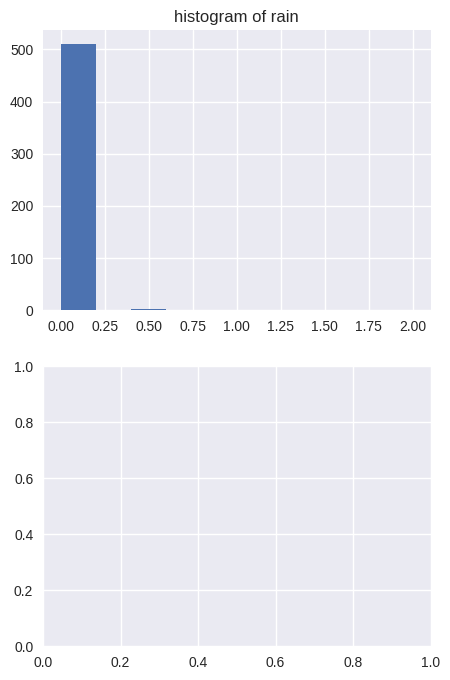

In [ ]:
# natural logarithm scaling (+1 to prevent errors at 0)
df.loc[:, ['rain']] = df.loc[:, ['rain']].apply(lambda x: np.log(x + 1), axis = 1)
# visualizing
fig, ax = plt.subplots(2, figsize = (5, 8))
ax[0].hist(df['rain'])
ax[0].title.set_text('histogram of rain')

In [ ]:
# Separate the dataset into two classes
class_a = df[df['size_category'] == 0]
class_b = df[df['size_category'] == 1]

# Count the number of rows in each class
num_class_a = len(class_a)
num_class_b = len(class_b)

# Determine the smaller class size
min_class_size = min(num_class_a, num_class_b)

# Randomly sample min_class_size number of rows from both classes
class_a_sampled = class_a.sample(n=(int)(min_class_size*0.8), random_state=42)
class_b_sampled = class_b.sample(n=(int)(min_class_size*0.8), random_state=42)

# Combine the sampled rows from both classes to create the training dataset
training_dataset = pd.concat([class_a_sampled, class_b_sampled])

# Remove the sampled rows from both classes to create the remaining data
class_a_remaining = class_a.drop(class_a_sampled.index)
class_b_remaining = class_b.drop(class_b_sampled.index)

# Combine the remaining rows from both classes to create the test dataset
test_dataset = pd.concat([class_a_remaining, class_b_remaining])

# Split the training dataset into features (X_train) and labels (y_train)
X_train = training_dataset.drop('size_category', axis=1)
y_train = training_dataset['size_category']

# Split the test dataset into features (X_test) and labels (y_test)
X_test = test_dataset.drop('size_category', axis=1)
y_test = test_dataset['size_category']


In [ ]:
features = df.drop(['size_category'], axis = 1)
labels = df['size_category'].values.reshape(-1, 1)
# X_train, X_test, y_train, y_test = train_test_split(features,labels, test_size = 0.2,stratify = labels, random_state = 42)

In [ ]:
# fitting scaler
sc_features = StandardScaler()
# transforming features
X_test = sc_features.fit_transform(X_test)
X_train = sc_features.transform(X_train)
# features
X_test = pd.DataFrame(X_test, columns = features.columns)
X_train = pd.DataFrame(X_train, columns = features.columns)
# labels
y_test = pd.DataFrame(y_test, columns = ['size_category'])
y_train = pd.DataFrame(y_train, columns = ['size_category'])
X_train.head()

,temp,RH,wind,rain
0,-1.366591,0.273797,0.770374,-0.090469
1,-0.317790,2.316994,0.290810,-0.090469
2,-0.888190,1.870044,-0.668320,-0.090469
3,1.540611,-1.386300,0.024385,-0.090469
4,1.595811,-1.258601,-0.934745,-0.090469


In [ ]:
import pickle
with open('forest_fire_scaler.pkl', 'wb') as f:
  pickle.dump(sc_features, f)

In [ ]:
model = Sequential()
# input layer + 1st hidden layer
model.add(Dense(16, input_dim=4, activation='relu'))
# 2nd hidden layer
model.add(Dense(8, activation='relu'))
# output layer
model.add(Dense(8, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation = 'sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16)                80        
                                                                 
 dense_1 (Dense)             (None, 8)                 136       
                                                                 
 dense_2 (Dense)             (None, 8)                 72        
                                                                 
 dropout (Dropout)           (None, 8)                 0         
                                                                 
 dense_3 (Dense)             (None, 1)                 9         
                                                                 
Total params: 297
Trainable params: 297
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Compile Model
model.compile(optimizer = 'adam', metrics=['accuracy'], loss ='binary_crossentropy')
model_path = "forest_fire_4.h5"

# Define the ModelCheckpoint callback
checkpoint_callback = ModelCheckpoint(model_path, monitor='accuracy', save_best_only=True, mode='max', verbose=1)
# Train Model
history = model.fit(X_train, y_train, validation_data = (X_test, y_test), batch_size = 10, epochs = 500, callbacks=[checkpoint_callback])

Epoch 1/500
15/23 [==================>...........] - ETA: 0s - loss: 0.6963 - accuracy: 0.4733 
Epoch 1: accuracy improved from -inf to 0.47748, saving model to forest_fire_4.h5
23/23 [==============================] - 2s 15ms/step - loss: 0.6976 - accuracy: 0.4775 - val_loss: 0.6600 - val_accuracy: 0.7288
Epoch 2/500
15/23 [==================>...........] - ETA: 0s - loss: 0.6879 - accuracy: 0.5333
Epoch 2: accuracy improved from 0.47748 to 0.52252, saving model to forest_fire_4.h5
23/23 [==============================] - 0s 9ms/step - loss: 0.7057 - accuracy: 0.5225 - val_loss: 0.6600 - val_accuracy: 0.7729
Epoch 3/500
17/23 [=====================>........] - ETA: 0s - loss: 0.7083 - accuracy: 0.5471
Epoch 3: accuracy did not improve from 0.52252
23/23 [==============================] - 0s 7ms/step - loss: 0.7063 - accuracy: 0.5225 - val_loss: 0.6689 - val_accuracy: 0.6339
Epoch 4/500
17/23 [=====================>........] - ETA: 0s - loss: 0.6883 - accuracy: 0.5059
Epoch 4: accuracy

In [ ]:
import tensorflow as tf
from sklearn.metrics import confusion_matrix

# Assuming you have test features as 'X_test'
predictions = model.predict(X_test)
predicted_labels = predictions # Get the predicted labels as the class with the highest probability

predicted_labels = predicted_labels
binary_labels = np.where(predictions > 0.5, 1, 0)
true_labels = y_test  # Assuming y_test is a TensorFlow tensor
confusion_matrix_np = confusion_matrix(true_labels, binary_labels)

print(confusion_matrix_np)

10/10 [==============================] - 0s 2ms/step
[[123 144]
 [ 11  17]]


In [ ]:
# Assuming you have test features as 'X_test'
predictions = model.predict(X_train)
predicted_labels = predictions # Get the predicted labels as the class with the highest probability

predicted_labels = predicted_labels
binary_labels = np.where(predictions > 0.5, 1, 0)
true_labels = y_train  # Assuming y_test is a TensorFlow tensor
confusion_matrix_np = confusion_matrix(true_labels, binary_labels)

print(confusion_matrix_np)

7/7 [==============================] - 0s 2ms/step
[[ 96  15]
 [  6 105]]


In [ ]:
_, train_acc = model.evaluate(X_train, y_train, verbose=0)
_, valid_acc = model.evaluate(X_test, y_test, verbose=0)
print('Train: %.3f, Valid: %.3f' % (train_acc, valid_acc))

Train: 0.784, Valid: 0.458


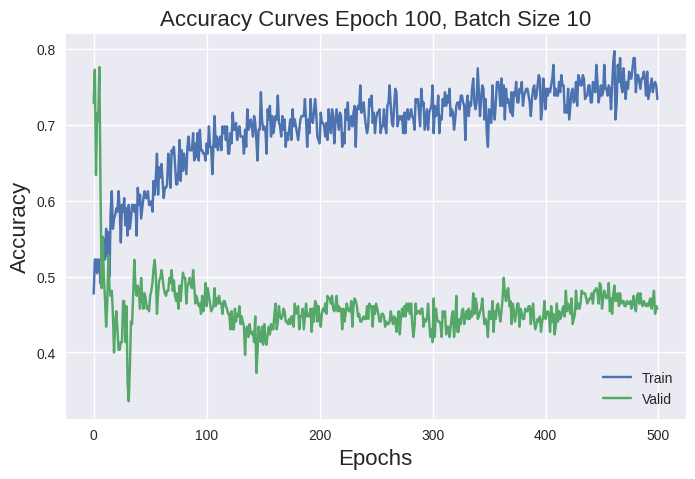

In [ ]:
plt.figure(figsize=[8,5])
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Valid')
plt.legend()
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.title('Accuracy Curves Epoch 100, Batch Size 10', fontsize=16)
plt.show()

In [ ]:
model.fit(X_train, y_train, validation_data = (X_test, y_test), batch_size = 10, epochs = 500, callbacks=[checkpoint_callback])

Epoch 1/500
16/23 [===================>..........] - ETA: 0s - loss: 0.4892 - accuracy: 0.7688
Epoch 1: accuracy did not improve from 0.79730
23/23 [==============================] - 0s 8ms/step - loss: 0.4750 - accuracy: 0.7838 - val_loss: 0.9030 - val_accuracy: 0.4475
Epoch 2/500
16/23 [===================>..........] - ETA: 0s - loss: 0.4768 - accuracy: 0.7812
Epoch 2: accuracy improved from 0.79730 to 0.80180, saving model to forest_fire_4.h5
23/23 [==============================] - 0s 8ms/step - loss: 0.4622 - accuracy: 0.8018 - val_loss: 0.8912 - val_accuracy: 0.4610
Epoch 3/500
17/23 [=====================>........] - ETA: 0s - loss: 0.4851 - accuracy: 0.7824
Epoch 3: accuracy did not improve from 0.80180
23/23 [==============================] - 0s 7ms/step - loss: 0.4729 - accuracy: 0.7793 - val_loss: 0.8937 - val_accuracy: 0.4475
Epoch 4/500
13/23 [===============>..............] - ETA: 0s - loss: 0.4587 - accuracy: 0.7692
Epoch 4: accuracy did not improve from 0.80180
23/23 [

In [ ]:
scalar = StandardScaler()

with open('forest_fire_scaler.pkl', 'rb') as f:
  scaler = pickle.load(f)

X_try = scalar.transform(X_train)

NotFittedError: ignored

In [ ]:
from joblib import dump, load

dump(sc_features, 'scalar.bin')

scalar = load('scalar.bin')

In [ ]:
X_try = scalar.transform(X_train)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


In [ ]:
X_try.shape

(222, 4)